# Simplified P2P Federated Learning Analysis

This notebook analyzes the 5 essential metrics for decentralized P2P experiments:
1. **Accuracy** of each client overall for each round
2. **Accuracy per class** of each client for each round
3. **Loss** per round of each client
4. **Gradient norm** of each client per round
5. **Gradient changes** per round of each client

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

print("Setup complete!")

Setup complete!


## Load Experiment Data

In [53]:
# Specify experiment directory
logs_base = Path('logs')

# Auto-detect latest P2P experiment
p2p_dirs = [d for d in logs_base.glob('*') if d.is_dir() and 
            any(x in d.name.lower() for x in ['metropolis', 'max_degree', 'jaccard', 'matcha', 'p2p'])]

if p2p_dirs:
    experiment_dir = max(p2p_dirs, key=lambda p: p.stat().st_mtime)
    subdirs = sorted([d for d in experiment_dir.iterdir() if d.is_dir()], reverse=True)
    if subdirs:
        experiment_dir = subdirs[0]
else:
    # Manually specify
    experiment_dir = logs_base / 'metropolis_hastings_comparison' / '2026-02-05_12-00-00'

print(f"Analyzing: {experiment_dir.name}")
print(f"Path: {experiment_dir}")

# Load data
df = pd.read_csv(experiment_dir / 'p2p_metrics.csv')
df_class = pd.read_csv(experiment_dir / 'p2p_per_class_metrics.csv')

print(f"\nLoaded {len(df)} overall metrics")
print(f"Loaded {len(df_class)} per-class metrics")
print(f"\nClients: {df['client_id'].nunique()}")
print(f"Rounds: {df['round'].max()}")
print(f"Classes: {df_class['class_id'].nunique()}")

Analyzing: 2026-02-05_15-34-49
Path: logs\matcha_comparison\2026-02-05_15-34-49

Loaded 12 overall metrics
Loaded 120 per-class metrics

Clients: 6
Rounds: 2
Classes: 10


## 1. Overall Accuracy per Client

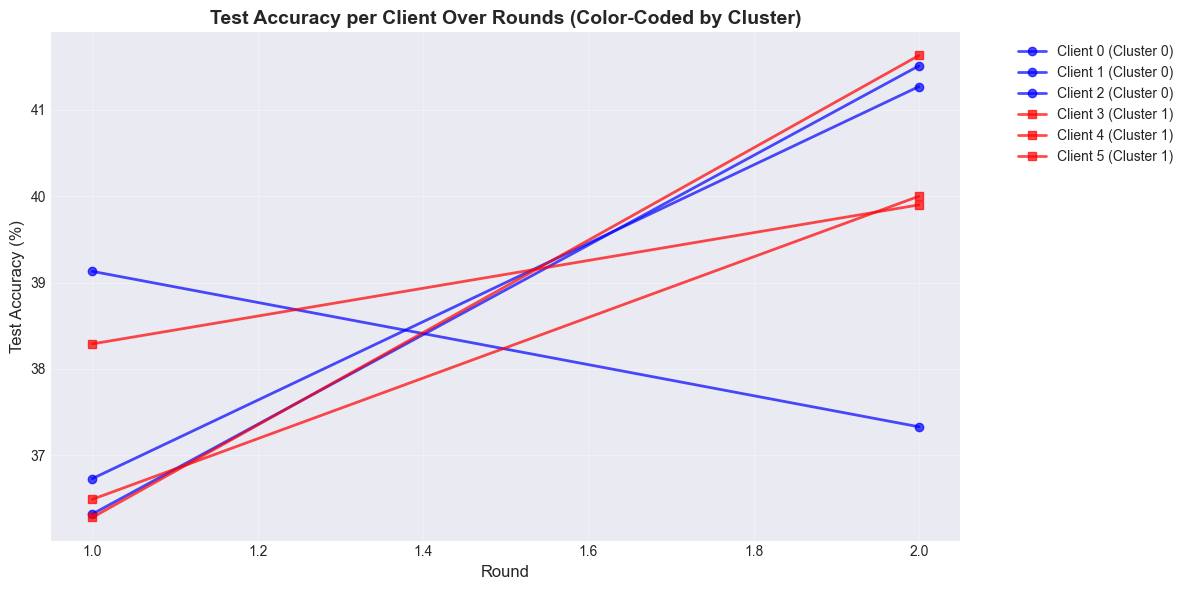


Final Round Accuracy:
  Mean: 40.27%
  Std: 1.63%
  Min: 37.33% (Client 0)
  Max: 41.63% (Client 4)

Cluster-wise Accuracy:
  Cluster 0: 40.04% ± 2.35%
  Cluster 1: 40.51% ± 0.97%


In [54]:
plt.figure(figsize=(12, 6))

# Define colors and markers for each cluster
cluster_colors = {0: 'blue', 1: 'red', None: 'gray'}
cluster_markers = {0: 'o', 1: 's', None: '^'}
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', None: 'No Cluster'}

for client_id in sorted(df['client_id'].unique()):
    client_data = df[df['client_id'] == client_id]
    cluster_id = client_data['cluster_id'].iloc[0] if 'cluster_id' in df.columns else None
    
    color = cluster_colors.get(cluster_id, 'gray')
    marker = cluster_markers.get(cluster_id, 'o')
    cluster_label = cluster_labels.get(cluster_id, 'Unknown')
    
    plt.plot(client_data['round'], client_data['test_accuracy'], 
             marker=marker, linewidth=2, label=f'Client {client_id} ({cluster_label})',
             color=color, alpha=0.7)

plt.xlabel('Round', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Test Accuracy per Client Over Rounds (Color-Coded by Cluster)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
final_round = df['round'].max()
final_acc = df[df['round'] == final_round].groupby('client_id')['test_accuracy'].first()
print(f"\nFinal Round Accuracy:")
print(f"  Mean: {final_acc.mean():.2f}%")
print(f"  Std: {final_acc.std():.2f}%")
print(f"  Min: {final_acc.min():.2f}% (Client {final_acc.idxmin()})")
print(f"  Max: {final_acc.max():.2f}% (Client {final_acc.idxmax()})")

# Cluster-wise statistics if available
if 'cluster_id' in df.columns:
    final_data = df[df['round'] == final_round]
    print(f"\nCluster-wise Accuracy:")
    for cluster_id in sorted(final_data['cluster_id'].dropna().unique()):
        cluster_acc = final_data[final_data['cluster_id'] == cluster_id]['test_accuracy']
        print(f"  Cluster {int(cluster_id)}: {cluster_acc.mean():.2f}% ± {cluster_acc.std():.2f}%")

## 2. Loss per Client

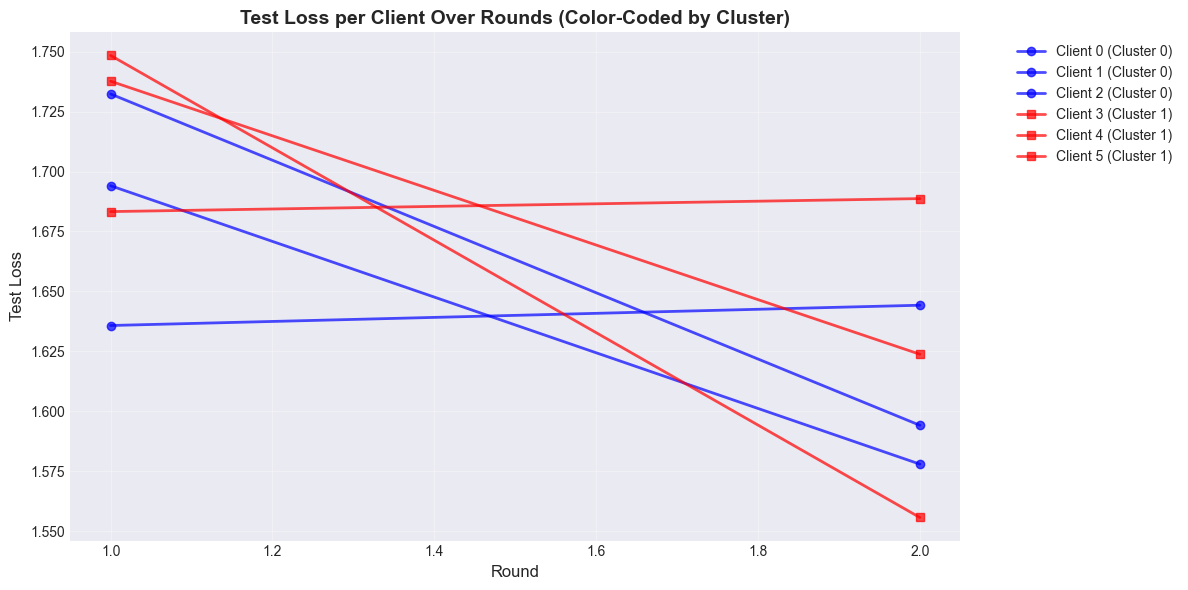


Final Round Loss:
  Mean: 1.6141
  Std: 0.0484
  Min: 1.5557 (Client 4)
  Max: 1.6887 (Client 5)


In [55]:
plt.figure(figsize=(12, 6))

for client_id in sorted(df['client_id'].unique()):
    client_data = df[df['client_id'] == client_id]
    cluster_id = client_data['cluster_id'].iloc[0] if 'cluster_id' in df.columns else None
    
    color = cluster_colors.get(cluster_id, 'gray')
    marker = cluster_markers.get(cluster_id, 's')
    cluster_label = cluster_labels.get(cluster_id, 'Unknown')
    
    plt.plot(client_data['round'], client_data['test_loss'], 
             marker=marker, linewidth=2, label=f'Client {client_id} ({cluster_label})',
             color=color, alpha=0.7)

plt.xlabel('Round', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.title('Test Loss per Client Over Rounds (Color-Coded by Cluster)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
final_loss = df[df['round'] == final_round].groupby('client_id')['test_loss'].first()
print(f"\nFinal Round Loss:")
print(f"  Mean: {final_loss.mean():.4f}")
print(f"  Std: {final_loss.std():.4f}")
print(f"  Min: {final_loss.min():.4f} (Client {final_loss.idxmin()})")
print(f"  Max: {final_loss.max():.4f} (Client {final_loss.idxmax()})")

## 3. Gradient Norm per Client

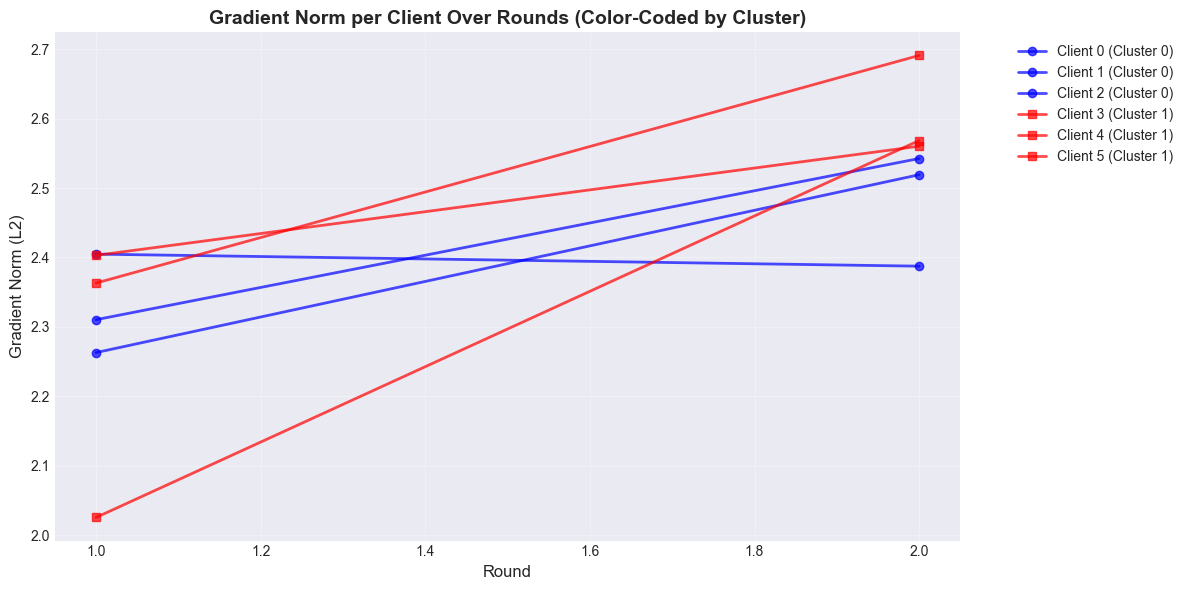


Final Round Gradient Norm:
  Mean: 2.5448
  Std: 0.0976
  Min: 2.3874 (Client 0)
  Max: 2.6910 (Client 5)


In [56]:
plt.figure(figsize=(12, 6))

for client_id in sorted(df['client_id'].unique()):
    client_data = df[df['client_id'] == client_id]
    cluster_id = client_data['cluster_id'].iloc[0] if 'cluster_id' in df.columns else None
    
    color = cluster_colors.get(cluster_id, 'gray')
    marker = cluster_markers.get(cluster_id, '^')
    cluster_label = cluster_labels.get(cluster_id, 'Unknown')
    
    plt.plot(client_data['round'], client_data['gradient_norm'], 
             marker=marker, linewidth=2, label=f'Client {client_id} ({cluster_label})',
             color=color, alpha=0.7)

plt.xlabel('Round', fontsize=12)
plt.ylabel('Gradient Norm (L2)', fontsize=12)
plt.title('Gradient Norm per Client Over Rounds (Color-Coded by Cluster)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
final_grad = df[df['round'] == final_round].groupby('client_id')['gradient_norm'].first()
print(f"\nFinal Round Gradient Norm:")
print(f"  Mean: {final_grad.mean():.4f}")
print(f"  Std: {final_grad.std():.4f}")
print(f"  Min: {final_grad.min():.4f} (Client {final_grad.idxmin()})")
print(f"  Max: {final_grad.max():.4f} (Client {final_grad.idxmax()})")

## 4. Gradient Changes per Client

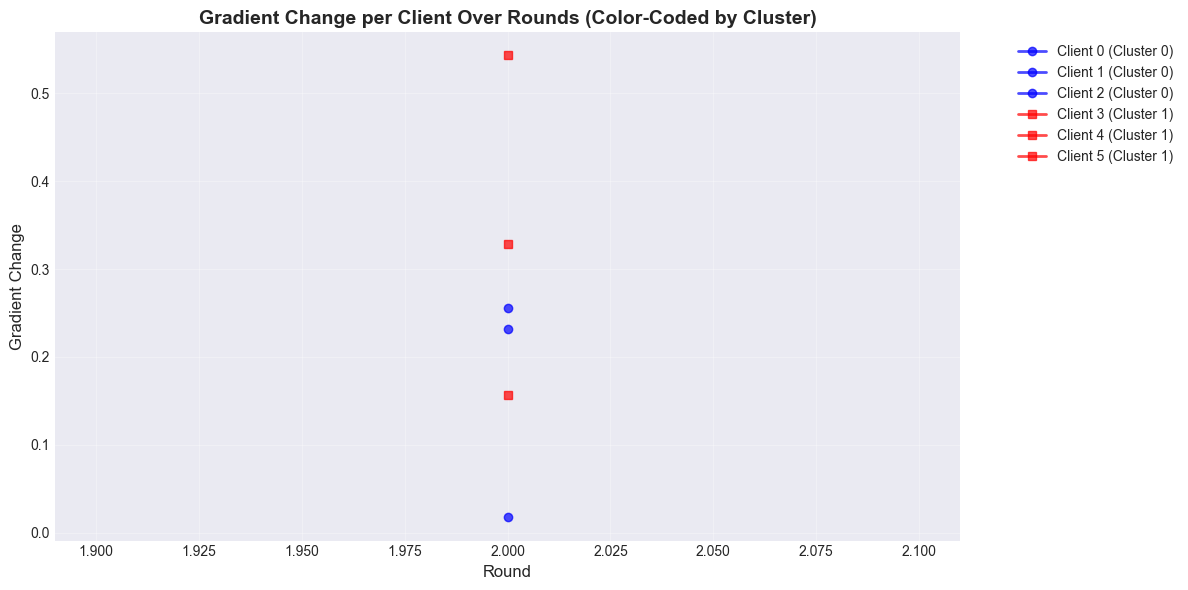


Gradient change shows how much the gradient norm changed from the previous round.
Lower values indicate convergence (gradients stabilizing).


In [57]:
plt.figure(figsize=(12, 6))

for client_id in sorted(df['client_id'].unique()):
    client_data = df[df['client_id'] == client_id]
    # Skip first round (gradient_change = 0)
    client_data_filtered = client_data[client_data['round'] > 1]
    cluster_id = client_data['cluster_id'].iloc[0] if 'cluster_id' in df.columns else None
    
    color = cluster_colors.get(cluster_id, 'gray')
    marker = cluster_markers.get(cluster_id, 'd')
    cluster_label = cluster_labels.get(cluster_id, 'Unknown')
    
    plt.plot(client_data_filtered['round'], client_data_filtered['gradient_change'], 
             marker=marker, linewidth=2, label=f'Client {client_id} ({cluster_label})',
             color=color, alpha=0.7)

plt.xlabel('Round', fontsize=12)
plt.ylabel('Gradient Change', fontsize=12)
plt.title('Gradient Change per Client Over Rounds (Color-Coded by Cluster)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nGradient change shows how much the gradient norm changed from the previous round.")
print("Lower values indicate convergence (gradients stabilizing).")

## 5. Per-Class Accuracy for Each Client

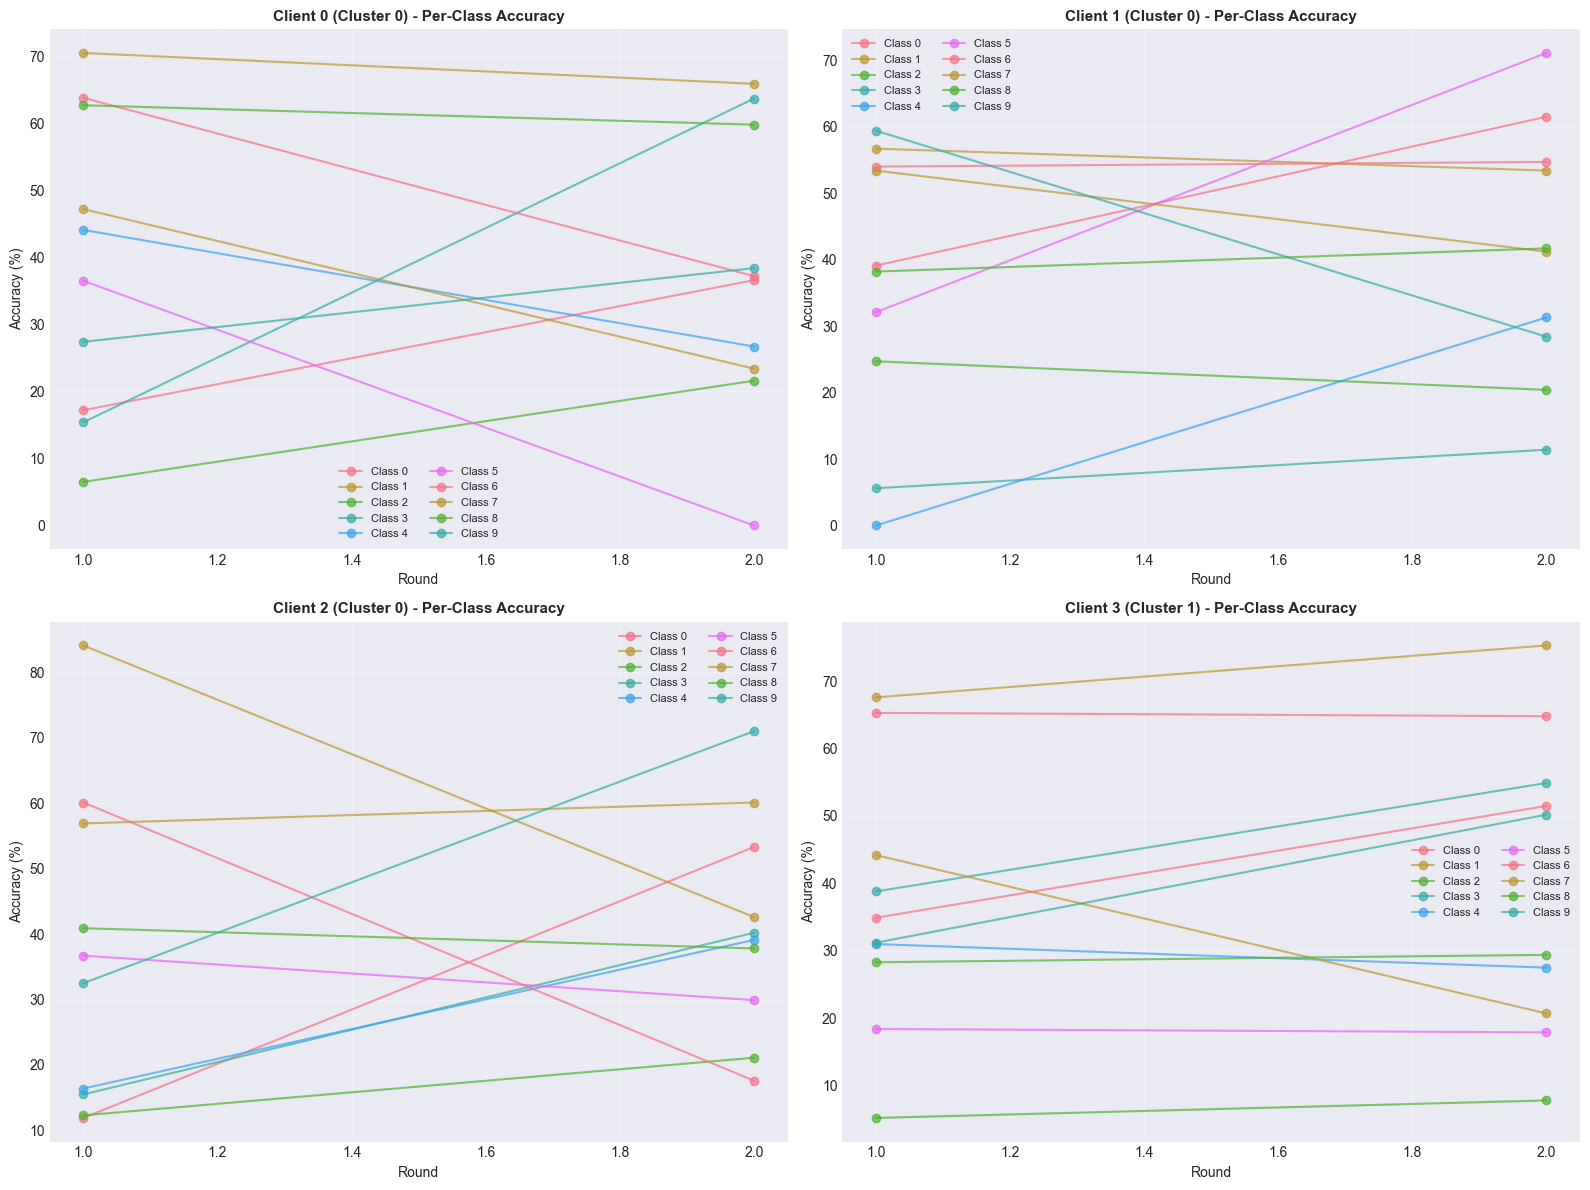

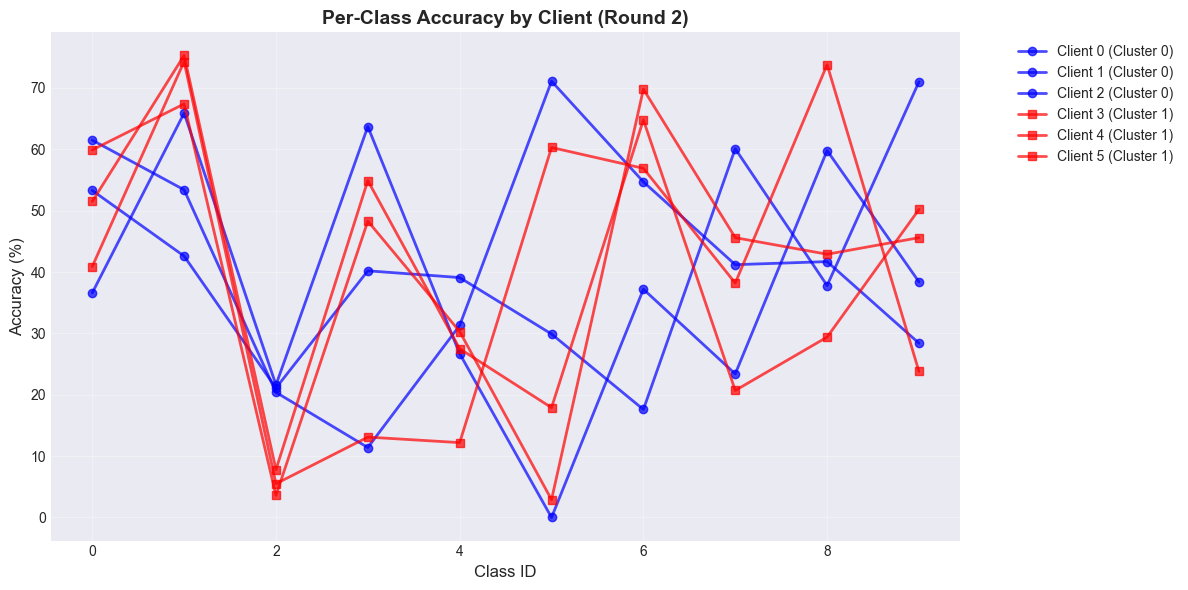

In [58]:
# Plot per-class accuracy for each client separately
num_clients = df_class['client_id'].nunique()
num_classes = df_class['class_id'].nunique()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, client_id in enumerate(sorted(df_class['client_id'].unique())):
    if idx >= 4:  # Only plot first 4 clients if more exist
        break
    
    ax = axes[idx]
    client_class_data = df_class[df_class['client_id'] == client_id]
    cluster_id = client_class_data['cluster_id'].iloc[0] if 'cluster_id' in df_class.columns else None
    cluster_label = cluster_labels.get(cluster_id, 'Unknown')
    
    for class_id in sorted(client_class_data['class_id'].unique()):
        class_data = client_class_data[client_class_data['class_id'] == class_id]
        ax.plot(class_data['round'], class_data['class_accuracy'], 
               marker='o', linewidth=1.5, alpha=0.7, label=f'Class {class_id}')
    
    ax.set_xlabel('Round', fontsize=10)
    ax.set_ylabel('Accuracy (%)', fontsize=10)
    ax.set_title(f'Client {client_id} ({cluster_label}) - Per-Class Accuracy', fontsize=11, fontweight='bold')
    ax.legend(ncol=2, fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Per-class accuracy line plot (final round) - color-coded by cluster
final_class_data = df_class[df_class['round'] == final_round]

plt.figure(figsize=(12, 6))
for client_id in sorted(final_class_data['client_id'].unique()):
    client_data = final_class_data[final_class_data['client_id'] == client_id]
    client_data_sorted = client_data.sort_values('class_id')
    cluster_id = client_data['cluster_id'].iloc[0] if 'cluster_id' in df_class.columns else None
    
    color = cluster_colors.get(cluster_id, 'gray')
    marker = cluster_markers.get(cluster_id, 'o')
    cluster_label = cluster_labels.get(cluster_id, 'Unknown')
    
    plt.plot(client_data_sorted['class_id'], client_data_sorted['class_accuracy'], 
            marker=marker, linewidth=2, alpha=0.7, 
            label=f'Client {client_id} ({cluster_label})',
            color=color)

plt.xlabel('Class ID', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title(f'Per-Class Accuracy by Client (Round {final_round})', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Per-Class Precision, Recall, F1-Score

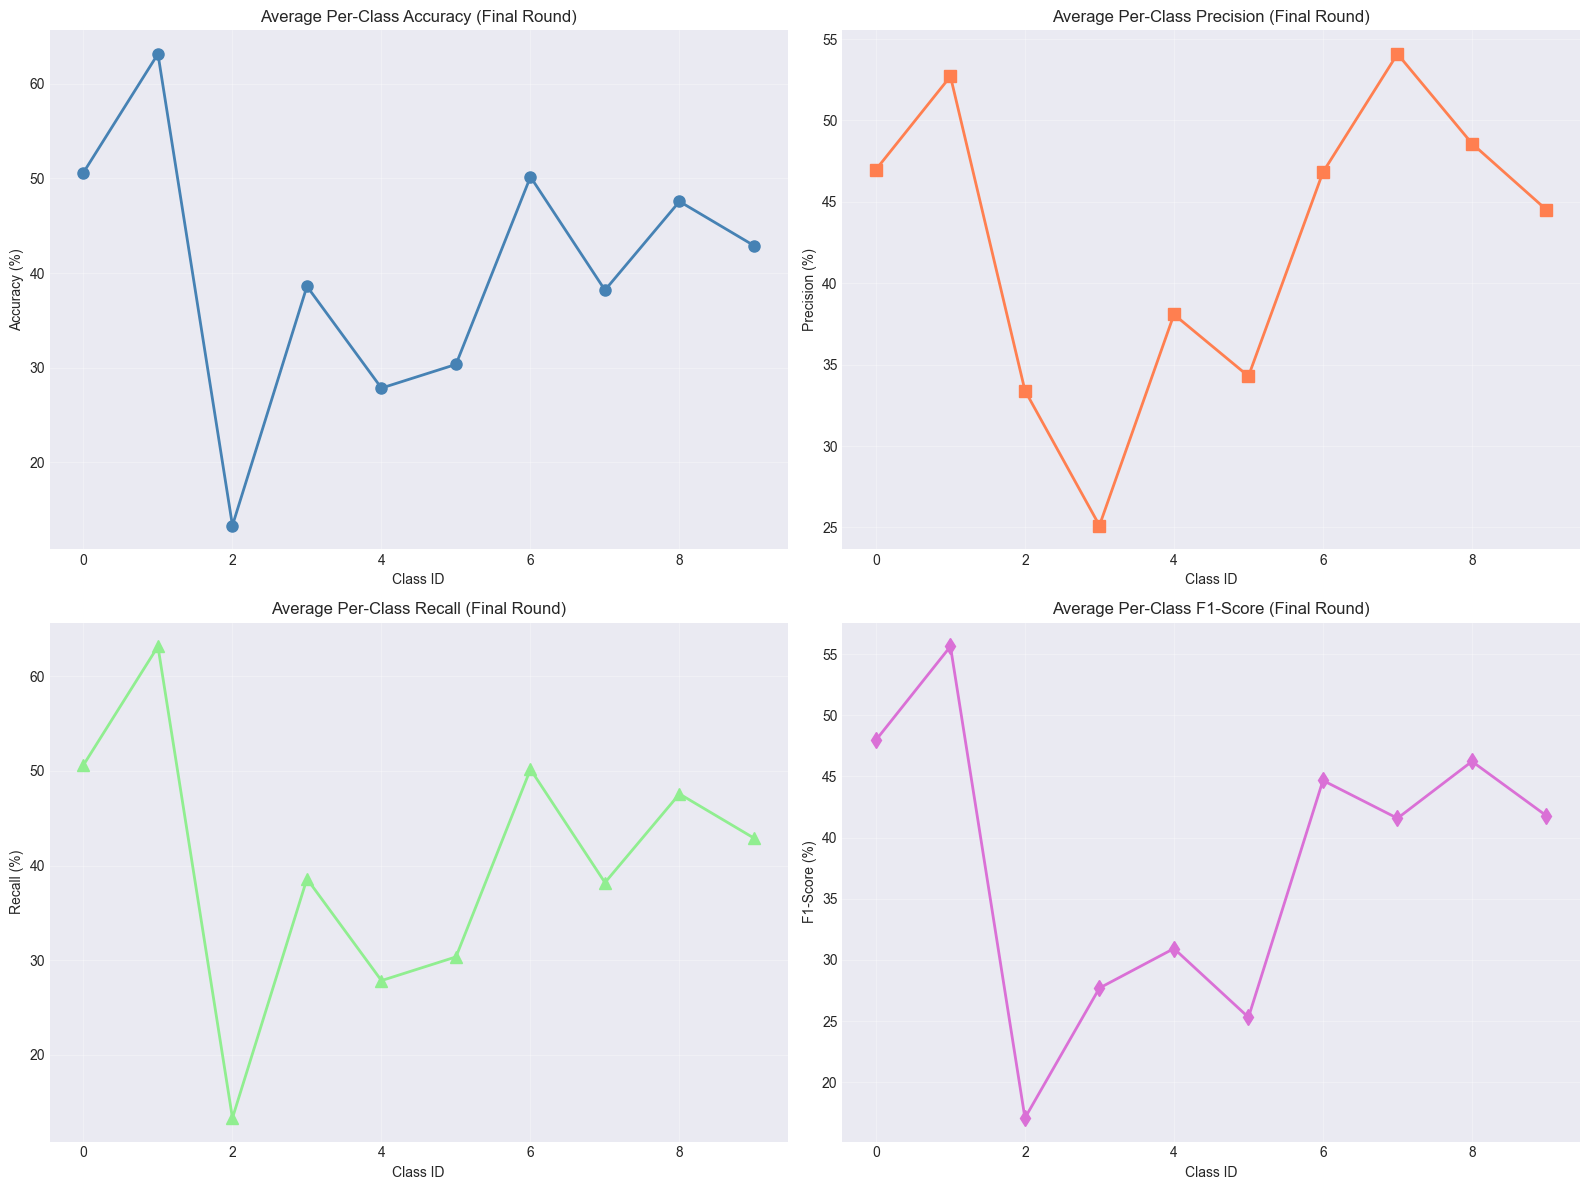

          class_accuracy  class_precision  class_recall  class_f1_score
class_id                                                               
0                  50.62            46.99         50.62           47.97
1                  63.15            52.71         63.15           55.62
2                  13.33            33.41         13.33           17.09
3                  38.60            25.12         38.60           27.71
4                  27.85            38.08         27.85           30.94
5                  30.35            34.29         30.35           25.32
6                  50.17            46.82         50.17           44.67
7                  38.20            54.09         38.20           41.58
8                  47.57            48.58         47.57           46.23
9                  42.90            44.51         42.90           41.78

Average Per-Class Metrics (Final Round):


In [59]:
# Average metrics across all clients for final round
final_class_data = df_class[df_class['round'] == final_round]
avg_per_class = final_class_data.groupby('class_id').agg({
    'class_accuracy': 'mean',
    'class_precision': 'mean',
    'class_recall': 'mean',
    'class_f1_score': 'mean'
})

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].plot(avg_per_class.index, avg_per_class['class_accuracy'], 
                marker='o', linewidth=2, color='steelblue', markersize=8)
axes[0, 0].set_xlabel('Class ID')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_title('Average Per-Class Accuracy (Final Round)')
axes[0, 0].grid(True, alpha=0.3)

# Precision
axes[0, 1].plot(avg_per_class.index, avg_per_class['class_precision'], 
                marker='s', linewidth=2, color='coral', markersize=8)
axes[0, 1].set_xlabel('Class ID')
axes[0, 1].set_ylabel('Precision (%)')
axes[0, 1].set_title('Average Per-Class Precision (Final Round)')
axes[0, 1].grid(True, alpha=0.3)

# Recall
axes[1, 0].plot(avg_per_class.index, avg_per_class['class_recall'], 
                marker='^', linewidth=2, color='lightgreen', markersize=8)
axes[1, 0].set_xlabel('Class ID')
axes[1, 0].set_ylabel('Recall (%)')
axes[1, 0].set_title('Average Per-Class Recall (Final Round)')
axes[1, 0].grid(True, alpha=0.3)

# F1-Score
axes[1, 1].plot(avg_per_class.index, avg_per_class['class_f1_score'], 
                marker='d', linewidth=2, color='orchid', markersize=8)
axes[1, 1].set_xlabel('Class ID')
axes[1, 1].set_ylabel('F1-Score (%)')
axes[1, 1].set_title('Average Per-Class F1-Score (Final Round)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

plt.show()
print(avg_per_class.round(2))

print(f"\nAverage Per-Class Metrics (Final Round):")

## 7. Summary Statistics

In [60]:
print("=" * 80)
print("P2P FEDERATED LEARNING - EXPERIMENT SUMMARY")
print("=" * 80)

print(f"\n📊 OVERALL METRICS")
print("-" * 80)
print(f"  Clients: {df['client_id'].nunique()}")
print(f"  Rounds: {df['round'].max()}")
print(f"  Classes: {df_class['class_id'].nunique()}")

final_round = df['round'].max()
final_data = df[df['round'] == final_round]

print(f"\n🎯 FINAL ROUND PERFORMANCE (Round {final_round})")
print("-" * 80)
print(f"  Accuracy:")
print(f"    Mean: {final_data['test_accuracy'].mean():.2f}%")
print(f"    Std:  {final_data['test_accuracy'].std():.2f}%")
print(f"    Range: [{final_data['test_accuracy'].min():.2f}%, {final_data['test_accuracy'].max():.2f}%]")

print(f"\n  Loss:")
print(f"    Mean: {final_data['test_loss'].mean():.4f}")
print(f"    Std:  {final_data['test_loss'].std():.4f}")
print(f"    Range: [{final_data['test_loss'].min():.4f}, {final_data['test_loss'].max():.4f}]")

print(f"\n  Gradient Norm:")
print(f"    Mean: {final_data['gradient_norm'].mean():.4f}")
print(f"    Std:  {final_data['gradient_norm'].std():.4f}")

# Convergence analysis
first_round = df[df['round'] == 1]
accuracy_improvement = final_data['test_accuracy'].mean() - first_round['test_accuracy'].mean()
loss_improvement = first_round['test_loss'].mean() - final_data['test_loss'].mean()

print(f"\n📈 CONVERGENCE")
print("-" * 80)
print(f"  Accuracy Improvement: {accuracy_improvement:.2f}%")
print(f"  Loss Reduction: {loss_improvement:.4f}")

# Per-class summary
final_class_data = df_class[df_class['round'] == final_round]
print(f"\n📋 PER-CLASS PERFORMANCE (Average Across Clients)")
print("-" * 80)
avg_class_metrics = final_class_data.groupby('class_id').agg({
    'class_accuracy': 'mean',
    'class_precision': 'mean',
    'class_recall': 'mean',
    'class_f1_score': 'mean'
})
print(f"  Mean Accuracy: {avg_class_metrics['class_accuracy'].mean():.2f}%")
print(f"  Mean Precision: {avg_class_metrics['class_precision'].mean():.2f}%")
print(f"  Mean Recall: {avg_class_metrics['class_recall'].mean():.2f}%")
print(f"  Mean F1-Score: {avg_class_metrics['class_f1_score'].mean():.2f}%")

print("\n" + "=" * 80)
print(f"Results location: {experiment_dir}")
print("=" * 80)

P2P FEDERATED LEARNING - EXPERIMENT SUMMARY

📊 OVERALL METRICS
--------------------------------------------------------------------------------
  Clients: 6
  Rounds: 2
  Classes: 10

🎯 FINAL ROUND PERFORMANCE (Round 2)
--------------------------------------------------------------------------------
  Accuracy:
    Mean: 40.27%
    Std:  1.63%
    Range: [37.33%, 41.63%]

  Loss:
    Mean: 1.6141
    Std:  0.0484
    Range: [1.5557, 1.6887]

  Gradient Norm:
    Mean: 2.5448
    Std:  0.0976

📈 CONVERGENCE
--------------------------------------------------------------------------------
  Accuracy Improvement: 3.07%
  Loss Reduction: 0.0912

📋 PER-CLASS PERFORMANCE (Average Across Clients)
--------------------------------------------------------------------------------
  Mean Accuracy: 40.27%
  Mean Precision: 42.46%
  Mean Recall: 40.27%
  Mean F1-Score: 37.89%

Results location: logs\matcha_comparison\2026-02-05_15-34-49
